# Classification of patterns on the atmosphere of extra solar hot Jupiter

*Martial Mancip (Maison de la Simulation, Saclay), François Caud, Thomas Moreau (DATAIA, Univ. Paris-Saclay)*

<div>
<table style="width:100%; background-color:transparent;">
  <tr style="background-color:transparent;">
    <td align="left"; style="background-color:transparent; width: 40%;">
        <a href="https://dataia.eu">
            <img src="https://github.com/ramp-kits/tephra/raw/main/img/DATAIA-h.png" width="450px"/>
        </a>
    </td>
    <td align="right"; style="background-color:transparent; width: 40%;">
        <a href="https://mdls.fr/">
            <img src="img/cropped-mdls_logo_texte-1024x421-1.png" width="350px"/>
        </a>
    </td>
  </tr>
 </table>
</div>

## Introduction


In-order to understand the results of recent observations of exoplanets, physics-based models have become increasingly complex.
Unfortunately this increases both the computational cost and output size of said models. We intend to explore if AI-image-recognition can alleviate this burden.
[DYNAMICO](https://www.lmd.polytechnique.fr/~dubos/DYNAMICO/) was used to run a series of HD209458-like simulations with different orbital-radii.
Simulations fall into two regimes: simulations with a shorter orbital-radii exhibit significant global mixing which shapes the entire atmospheres dynamics. Whereas, simulations with longer orbital-radii exhibit negligible mixing except at mid-pressures.
It is believed that image-classification may play an important role in future, computational, atmospheric studies.
However special care must be paid to the data feed into the model, from the colourmap, to training the CNN on features with enough breadth and complexity that the CNN can learn to detect them. However, by using preliminary-studies and prior-models, this should be more than achievable for future exascale calculations, allowing for a significant reduction in future workloads and computational resources.


Patterns detected and labeled in simulated temperature maps are:
- day-side hot-spots in which the zonal winds have caused significant horizontal thermal advection (and whose shape is typically referred to as a butterfly in the hot Jupiter community - e.g. Figure b/c) -> **butterfly**
- longitudinally homogenised and latitudinally symmetric thermal bands (e.g. Figure d) -> **banded**
- day-side hot-spots in which radiative affects dominate over advective dynamics (i.e. an irradiative hot-spot which has not been
significantly advected by horizontal winds - e.g. Figure e and Figure a to a lesser extent) -> **locked**
- latitudinally asymmetric thermal structures (see, e.g. Figure h) -> **asymetric**

The simulation data-set comprises examples with orbital radii between 0.012au and 0.334au.

The goal of this challenge is to find ML models capable of classifying those patterns on images from physics-based simulations.


| ![patterns.png](./img/patterns.png) |
|:--:|
| <b>Examples of patterns in simulations of the atmosphere of an extra hot Jupiter (from [this article](https://arxiv.org/abs/2309.10640); see for more details)</b>|


## Requirements

In [1]:
%%capture capt
!pip install torch torchvision

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import time

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from torchvision import transforms, models
from sklearn.metrics import accuracy_score, balanced_accuracy_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import classification_report
from sklearn.model_selection import LeaveOneGroupOut

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Running on {device}")

Running on cuda


## Data exploration

Data consist of simulated grey-scale images of temperature maps on the surface of Hot Jupiter extra solar planets. We have five target labels corresponding to the four pattern classes plus a negative class (no pattern) :

In [3]:
CLASSES = ["asymetric", "banded", "locked", "butterfly", "no_pattern"]

Here is the mapping between integers and categories:

In [4]:
# Mapping int to categories
int_to_cat = {
    0: "asymetric",
    1: "banded",
    2: "locked",
    3: "butterfly",
    4: "no_pattern",
}

In [5]:
list(int_to_cat)

[0, 1, 2, 3, 4]

### Train set

The training set has 620 examples:

In [6]:
X_train = np.load("./data/X_train.npy")
X_train.shape

(620, 90, 180)

Images are 90 x 180

In [7]:
y_train_df = pd.read_csv("./data/y_train.csv")
y_train_df

,simulation,category,cat_num
0,Hot_0036_Locked,banded,1
1,Hot_0036_Locked,banded,1
2,Hot_0021_match,banded,1
3,Hot_0021_Locked,banded,1
4,Hot_0012_Locked,banded,1
...,...,...,...
615,Cool_0334_Locked,no_pattern,4
616,Hot_0021_Locked,no_pattern,4
617,Hot_0036_Locked,no_pattern,4
618,Hot_0012_Locked,banded,1


#### Distribution of classes in the train set:

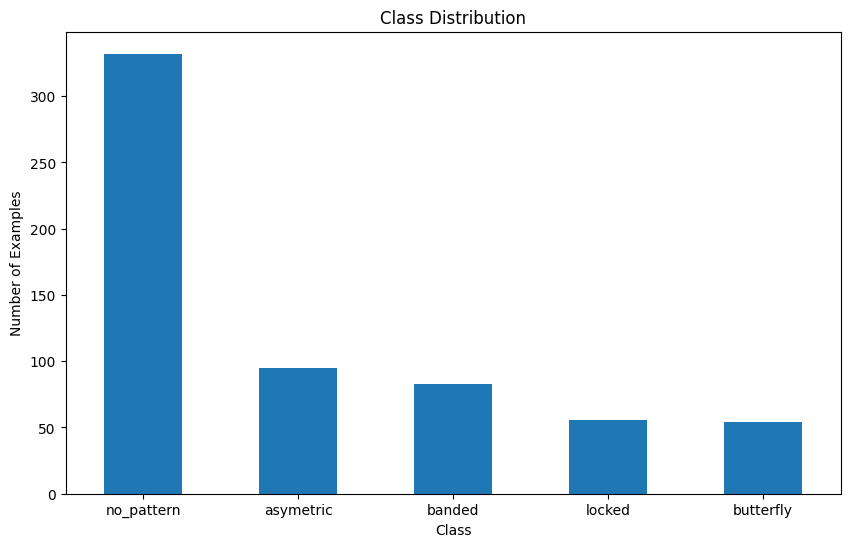

In [8]:
class_counts = y_train_df['category'].value_counts()

plt.figure(figsize=(10, 6))
class_counts.plot(kind='bar')
plt.title('Class Distribution')
plt.xlabel('Class')
plt.ylabel('Number of Examples')
plt.xticks(rotation=0)
plt.show()

Classes are imbalanced with the no_pattern one dominating.

#### Plot of the average image for each class:

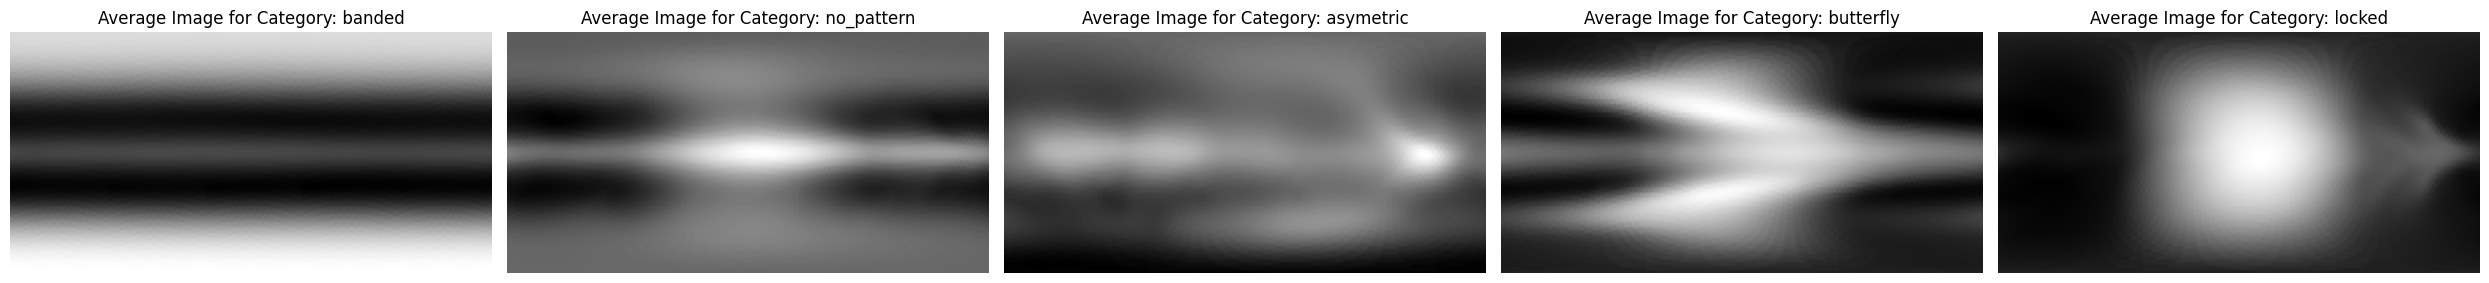

In [9]:
unique_categories = y_train_df['category'].unique()
num_categories = len(unique_categories)
fig, axes = plt.subplots(1, num_categories, figsize=(5 * num_categories, 5))

for i, category in enumerate(unique_categories):
    # Get the indices for the current category
    category_indices = y_train_df[y_train_df['category'] == category].index
    # Select the images belonging to the current category
    category_images = X_train[category_indices]
    # Calculate the average image
    average_image = np.mean(category_images, axis=0)

    ax = axes[i]
    ax.imshow(average_image, cmap='gray')
    ax.set_title(f'Average Image for Category: {category}')
    ax.axis('off')

plt.tight_layout()
plt.show()

### Test set

Testing set has 68 examples:

In [10]:
X_test = np.load("./data/X_test.npy")
X_test.shape

(68, 90, 180)

In [11]:
y_test_df = pd.read_csv("./data/y_test.csv")
y_test_df

,simulation,category,cat_num
0,Hot_0036_match,banded,1
1,Cool_0192_Locked,asymetric,0
2,Cool_0192_Locked,asymetric,0
3,Cool_0192_Locked,no_pattern,4
4,Cool_0192_Locked,no_pattern,4
...,...,...,...
63,Cool_0192_Locked,no_pattern,4
64,Hot_0036_match,banded,1
65,Hot_0036_match,no_pattern,4
66,Cool_0192_Locked,no_pattern,4


#### Distribution of classes in test set:

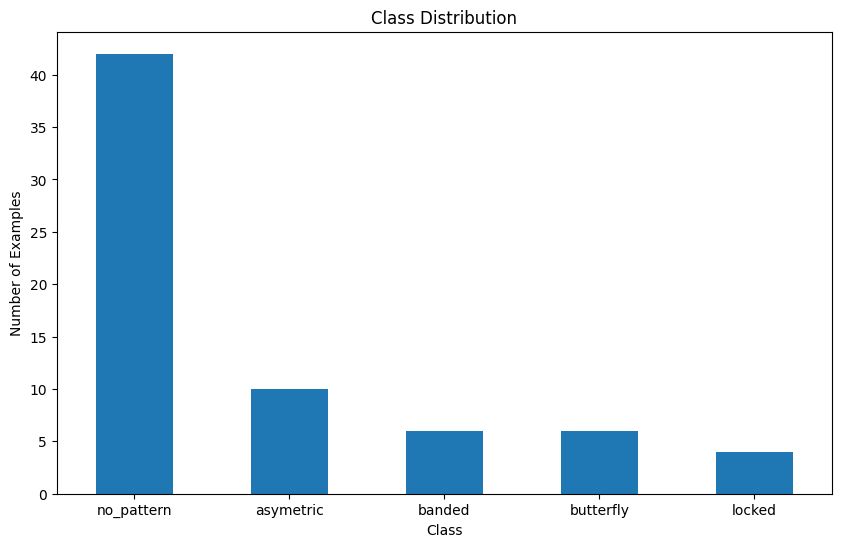

In [12]:
class_counts = y_test_df['category'].value_counts()

plt.figure(figsize=(10, 6))
class_counts.plot(kind='bar')
plt.title('Class Distribution')
plt.xlabel('Class')
plt.ylabel('Number of Examples')
plt.xticks(rotation=0)
plt.show()

## Base model

We will use a pretrained CNN model (MobileNet trained on ImageNet dataset). The model is loaded and all the weights are freezed. We just replace the last fully-connected layer to be trained.

In [13]:
def create_modified_mobilenet(num_classes):
    # Load a pretrained MobileNet model
    model = models.vit_b_16(weights='IMAGENET1K_V1')

    # Freeze all layers in the network
    for param in model.parameters():
        param.requires_grad = False

    # Replace the last fully connected layer
    # Parameters of newly constructed modules have requires_grad=True by default
    num_features = model.heads[0].in_features
    model.heads[0] = nn.Linear(num_features, num_classes, bias=True)

    return model

In [14]:
# labels
y_train = y_train_df.cat_num.values
print(y_train.shape)
y_test = y_test_df.cat_num.values
print(y_test.shape)

(620,)
(68,)


In [15]:
# Reshape data to add channel dimension
X_train = X_train.reshape(-1, 1, 90, 180)
X_test = X_test.reshape(-1, 1, 90, 180)
print(X_train.shape)
print(X_test.shape)

(620, 1, 90, 180)
(68, 1, 90, 180)


In [16]:
# Conversion from numpy arrays to Pytorch tensors
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.int64)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.int64)

We will need to convert images from grayscale to RBG format (1 to 3 channel dim) in order to accomodate with MobileNet inputs. We simply repeat gray image 2 more times.

In [17]:
class GrayscaleToRgb:
    def __call__(self, tensor):
        # tensor is a 1-channel grayscale image
        return tensor.repeat(3, 1, 1)

Furthermore, images have to be resized to (224, 224) and normalized:

In [18]:
transform = transforms.Compose([
    GrayscaleToRgb(),
    transforms.Resize((256, 256), antialias=True),
    transforms.CenterCrop((224, 224)),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

In [19]:
X_train_transformed = torch.stack([transform(x) for x in X_train_tensor])
X_train_transformed.shape

torch.Size([620, 3, 224, 224])

In [20]:
# Transform on test images:
X_test_transformed = torch.stack([transform(x) for x in X_test_tensor])
X_test_transformed.shape

torch.Size([68, 3, 224, 224])

In [21]:
# Labels:
print(y_train_tensor.shape)
print(y_test_tensor.shape)

torch.Size([620])
torch.Size([68])


We create DataLoader objects in order to train and predict on batches of images:

In [22]:
train_dataset = TensorDataset(X_train_transformed.to(device), y_train_tensor.to(device))
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)

In [23]:
test_dataset = TensorDataset(X_test_transformed.to(device), y_test_tensor.to(device))
test_loader = DataLoader(test_dataset, batch_size=32)

In [24]:
from sklearn.utils.class_weight import compute_class_weight

class_weights__train = compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)
class_weights__train = torch.tensor(class_weights__train, dtype=torch.float32).to(device)

class_weights__test = compute_class_weight('balanced', classes=np.unique(y_test), y=y_test)
class_weights__test = torch.tensor(class_weights__test, dtype=torch.float32).to(device)

print(class_weights__train, class_weights__test)

tensor([1.3053, 1.4940, 2.2143, 2.2963, 0.3735], device='cuda:0') tensor([1.3600, 2.2667, 3.4000, 2.2667, 0.3238], device='cuda:0')


In [25]:
def train_epoch(model, train_loader, criterion, optimizer):
    model.train()
    epoch_train_loss = 0.0
    all_predictions = []
    all_labels = []

    for images, labels in train_loader:
        #images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        epoch_train_loss += loss.item()

        # Collect predictions and labels for balanced accuracy calculation
        _, predictions = torch.max(outputs.data, 1)
        all_predictions.extend(predictions.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

    epoch_train_loss /= len(train_loader)

    # Calculate balanced accuracy on the training set
    train_balanced_acc = balanced_accuracy_score(all_labels, all_predictions)
    train_acc = accuracy_score(all_labels, all_predictions)

    return epoch_train_loss, train_acc, train_balanced_acc

In [26]:
def validate(model, val_loader, criterion):
    model.eval()
    epoch_val_loss = 0.0
    all_predictions = []
    all_labels = []

    with torch.no_grad():
        for images, labels in val_loader:
            outputs = model(images)
            loss = criterion(outputs, labels)
            epoch_val_loss += loss.item()

            _, predictions = torch.max(outputs.data, 1)
            all_predictions.extend(predictions.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    epoch_val_loss /= len(val_loader)
    balanced_acc = balanced_accuracy_score(all_labels, all_predictions)
    acc = accuracy_score(all_labels, all_predictions)
    return epoch_val_loss, acc, balanced_acc

In [58]:
def train_with_early_stopping(model, train_loader, val_loader, criterion, optimizer, num_epochs, plot_every=None, patience=np.inf):
    best_val_loss = float('inf')
    counter = 0

    def print_metrics(epoch):
      print(f"Epoch [{epoch+1}/{num_epochs}] - "
            f"Train Loss: {epoch_train_loss:.4f}, "
            f"Validation Loss: {epoch_val_loss:.4f}, "
            f"Train Accuracy: {train_accuracy:.4f}, "
            f"Valid Accuracy: {val_accuracy:.4f}, "
            f"Train Balanced Accuracy: {train_balanced_acc:.4f}, "
            f"Validation Balanced Accuracy: {val_balanced_acc:.4f}, "
            f"Time per epoch: {round(stop-start, 2)}s")

    if plot_every is None:
      plot_every = int(num_epochs/10)

    for epoch in range(num_epochs):
        # Training
        start = time.time()
        epoch_train_loss, train_accuracy, train_balanced_acc = train_epoch(model, train_loader, criterion, optimizer)
        train_losses.append(epoch_train_loss)
        train_accuracies.append(train_accuracy)
        train_balanced_accuracies.append(train_balanced_acc)

        # Validation
        epoch_val_loss, val_accuracy, val_balanced_acc = validate(model, val_loader, criterion)
        val_losses.append(epoch_val_loss)
        val_accuracies.append(val_accuracy)
        val_balanced_accuracies.append(val_balanced_acc)
        stop = time.time()

        if epoch % plot_every == 0 or epoch == num_epochs-1:
          print_metrics(epoch)

        # Patience mechanism
        if epoch_val_loss < best_val_loss:
            best_val_loss = epoch_val_loss
            counter = 0
            torch.save(model.state_dict(), "./model_dict.pt")
            torch.save(model, "./model.pt")
        else:
            counter += 1
            if counter >= patience:
                print_metrics(epoch)
                break

    return train_losses, val_losses, train_accuracies, val_accuracies, train_balanced_accuracies, val_balanced_accuracies

In [28]:
num_epochs = 2000
plot_every = 20
patience = 50

model = create_modified_mobilenet(num_classes=5).to(device)
criterion = nn.CrossEntropyLoss(weight=class_weights__train)
optimizer = optim.Adam(model.parameters(), lr=1e-6)

In [ ]:
train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []
train_balanced_accuracies = []
val_balanced_accuracies = []

In [59]:
train_losses, val_losses, train_accuracies, val_accuracies, train_balanced_accuracies, val_balanced_accuracies = train_with_early_stopping(
    model, train_loader, test_loader, criterion, optimizer, num_epochs, plot_every=plot_every, patience=patience
)

Epoch [1/500] - Train Loss: 0.7572, Validation Loss: 1.0213, Train Accuracy: 0.6758, Valid Accuracy: 0.3824, Train Balanced Accuracy: 0.8007, Validation Balanced Accuracy: 0.5676, Time per epoch: 13.81s
Epoch [21/500] - Train Loss: 0.7511, Validation Loss: 1.0177, Train Accuracy: 0.6758, Valid Accuracy: 0.3824, Train Balanced Accuracy: 0.8021, Validation Balanced Accuracy: 0.5676, Time per epoch: 13.91s
Epoch [41/500] - Train Loss: 0.7490, Validation Loss: 1.0140, Train Accuracy: 0.6758, Valid Accuracy: 0.3824, Train Balanced Accuracy: 0.8021, Validation Balanced Accuracy: 0.5676, Time per epoch: 13.9s
Epoch [61/500] - Train Loss: 0.7420, Validation Loss: 1.0106, Train Accuracy: 0.6758, Valid Accuracy: 0.3971, Train Balanced Accuracy: 0.8021, Validation Balanced Accuracy: 0.5724, Time per epoch: 13.91s
Epoch [81/500] - Train Loss: 0.7405, Validation Loss: 1.0072, Train Accuracy: 0.6774, Valid Accuracy: 0.3971, Train Balanced Accuracy: 0.8027, Validation Balanced Accuracy: 0.5724, Time 

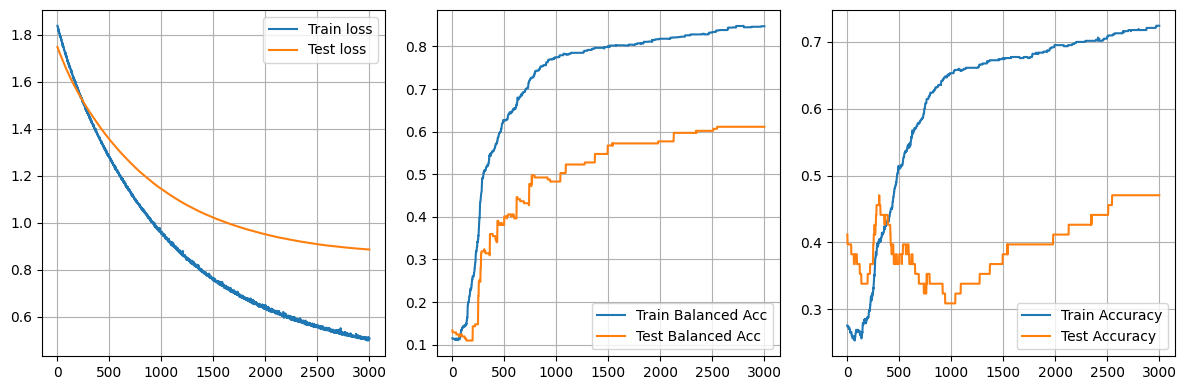

In [63]:
fig, axs = plt.subplots(1, 3, figsize=(12, 4))

axs[0].plot(train_losses, label='Train loss')
axs[0].plot(val_losses, label='Test loss')

axs[1].plot(train_balanced_accuracies, label='Train Balanced Acc')
axs[1].plot(val_balanced_accuracies, label='Test Balanced Acc')

axs[2].plot(train_accuracies, label='Train Accuracy')
axs[2].plot(val_accuracies, label='Test Accuracy')

for ax in axs:
    ax.legend()
    ax.grid('on')

plt.tight_layout()
plt.show()

In [61]:
torch.save(model.state_dict(), "./end_loop_model_dict.pt")
torch.save(model, "./end_loop_model.pt")

train_losses, val_losses, train_accuracies, val_accuracies, train_balanced_accuracies, val_balanced_accuracies = train_with_early_stopping(
    model, train_loader, test_loader, criterion, optimizer, num_epochs, plot_every=plot_every, patience=patience
)

Epoch [1/500] - Train Loss: 0.6357, Validation Loss: 0.9503, Train Accuracy: 0.6952, Valid Accuracy: 0.4118, Train Balanced Accuracy: 0.8181, Validation Balanced Accuracy: 0.5771, Time per epoch: 13.88s
Epoch [21/500] - Train Loss: 0.6299, Validation Loss: 0.9480, Train Accuracy: 0.6952, Valid Accuracy: 0.4118, Train Balanced Accuracy: 0.8181, Validation Balanced Accuracy: 0.5771, Time per epoch: 13.91s
Epoch [41/500] - Train Loss: 0.6306, Validation Loss: 0.9459, Train Accuracy: 0.6952, Valid Accuracy: 0.4118, Train Balanced Accuracy: 0.8181, Validation Balanced Accuracy: 0.5771, Time per epoch: 13.87s
Epoch [61/500] - Train Loss: 0.6276, Validation Loss: 0.9437, Train Accuracy: 0.6952, Valid Accuracy: 0.4118, Train Balanced Accuracy: 0.8181, Validation Balanced Accuracy: 0.5771, Time per epoch: 13.88s
Epoch [81/500] - Train Loss: 0.6222, Validation Loss: 0.9416, Train Accuracy: 0.6952, Valid Accuracy: 0.4118, Train Balanced Accuracy: 0.8181, Validation Balanced Accuracy: 0.5771, Time

In [ ]:
torch.save(model.state_dict(), "./end_loop2_model_dict.pt")
torch.save(model, "./end2_loop_model.pt")

train_losses, val_losses, train_accuracies, val_accuracies, train_balanced_accuracies, val_balanced_accuracies = train_with_early_stopping(
    model, train_loader, test_loader, criterion, optimizer, num_epochs, plot_every=plot_every, patience=patience
)

Epoch [1/500] - Train Loss: 0.5018, Validation Loss: 0.8854, Train Accuracy: 0.7242, Valid Accuracy: 0.4706, Train Balanced Accuracy: 0.8475, Validation Balanced Accuracy: 0.6114, Time per epoch: 13.78s
Epoch [21/500] - Train Loss: 0.4972, Validation Loss: 0.8847, Train Accuracy: 0.7242, Valid Accuracy: 0.4706, Train Balanced Accuracy: 0.8475, Validation Balanced Accuracy: 0.6114, Time per epoch: 13.95s


In [48]:
model.eval()
correct = 0
total = 0

with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

accuracy = correct / total
print(f'Accuracy on Test Data: {accuracy:.3f}')

Accuracy on Test Data: 0.382


Let's predict on the whole test dataset with the fitted model (we can do that because we only have 68 examples in the train set).

In [49]:
X_test_to_predict = X_test_transformed.to(device)

# Model in evaluation mode
model.eval()

with torch.no_grad():
    # Forward pass
    outputs = model(X_test_to_predict)
    _, y_pred = torch.max(outputs, 1)

    outputs_train = model(X_train_transformed.to(device))
    _, y_pred_train = torch.max(outputs_train, 1)

# Convert predictions to a numpy array
y_pred = y_pred.cpu().numpy()
y_pred_train = y_pred_train.cpu().numpy()

Accuracy score:

In [50]:
accuracy_score(y_test_tensor, y_pred), accuracy_score(y_train_tensor, y_pred_train)

(0.38235294117647056, 0.6758064516129032)

Balanced accuracy score:

In [51]:
balanced_accuracy_score(y_test_tensor, y_pred), balanced_accuracy_score(y_train_tensor, y_pred_train)

(0.5676190476190477, 0.800680164266087)

In [52]:
print(int_to_cat)

{0: 'asymetric', 1: 'banded', 2: 'locked', 3: 'butterfly', 4: 'no_pattern'}


In [53]:
print(classification_report(y_test_tensor, y_pred))

              precision    recall  f1-score   support

           0       0.21      0.60      0.31        10
           1       0.86      1.00      0.92         6
           2       0.31      1.00      0.47         4
           3       0.00      0.00      0.00         6
           4       0.53      0.24      0.33        42

    accuracy                           0.38        68
   macro avg       0.38      0.57      0.41        68
weighted avg       0.45      0.38      0.36        68



/opt/mamba/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/mamba/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/mamba/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Confusion matrix:

In [54]:
int_to_cat

{0: 'asymetric', 1: 'banded', 2: 'locked', 3: 'butterfly', 4: 'no_pattern'}

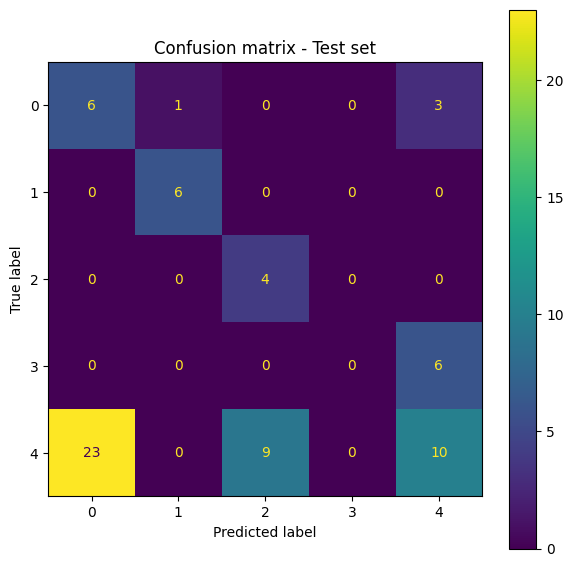

In [55]:
disp = ConfusionMatrixDisplay.from_predictions(y_test_tensor, y_pred)
fig = disp.figure_
fig.set_figwidth(7)
fig.set_figheight(7)
plt.title('Confusion matrix - Test set');

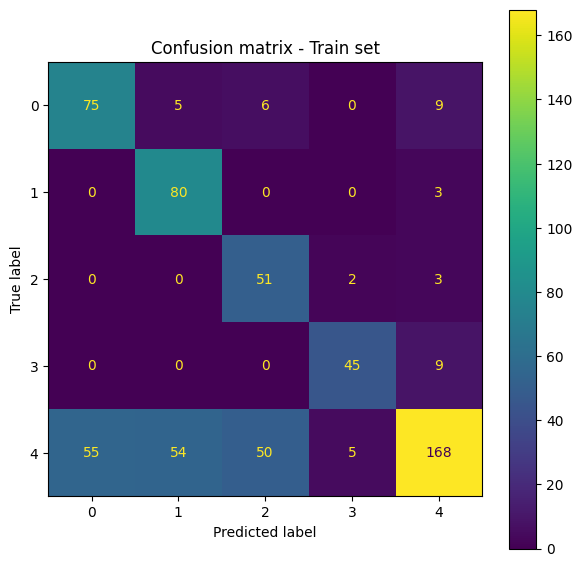

In [56]:
disp = ConfusionMatrixDisplay.from_predictions(y_train_tensor, y_pred_train)
fig = disp.figure_
fig.set_figwidth(7)
fig.set_figheight(7)
plt.title('Confusion matrix - Train set');

The model has difficulties to predict 'asymetric' and 'butterfly' classes and instead tag them as 'no_pattern'.
Classes 'banded' and 'locked' seem to be well predicted (on this small test dataset).

In order to better evaluate the model, RAMP uses cross-validation. Because data are grouped by simulations and those simulations comprise big chunck of data, we designed a CV strategy with meta groups that contains different simulations (group splitting) and the better repartition of examples from all the classes (stratified splitting). We will use LeaveOneGroupOut strategy on those meta groups.

## Cross-validation evaluation:

In [46]:
y_train_df

,simulation,category,cat_num
0,Hot_0036_Locked,banded,1
1,Hot_0036_Locked,banded,1
2,Hot_0021_match,banded,1
3,Hot_0021_Locked,banded,1
4,Hot_0012_Locked,banded,1
...,...,...,...
615,Cool_0334_Locked,no_pattern,4
616,Hot_0021_Locked,no_pattern,4
617,Hot_0036_Locked,no_pattern,4
618,Hot_0012_Locked,banded,1


#### Groups for cross-val:

In [47]:
# Create meta groups as a new column in y_train_df
# Simulations to groups dictionary
sim_to_group = {
    "Cool_0060_Locked": 0,
    "Cool_0110_match": 0,
    "Hot_0012_match": 0,
    "Hot_0036_Locked": 0,
    "Cool_0334_Locked": 1,
    "Hot_0012_Locked": 1,
    "Cool_0060_match": 1,
    "Cool_0110_Locked": 2,
    "Cool_0192_match": 2,
    "Cool_0334_match": 2,
    "Hot_0021_Locked": 2,
    "Hot_0021_match": 2,
}
# Function to apply to each row in the 'simulation' column
def get_group(simulation):
    return sim_to_group.get(simulation, None)
# Create a new column 'group' based on the 'simulation' column
y_train_df["group"] = y_train_df["simulation"].apply(get_group)
# Gobal variable groups
global groups
groups = y_train_df.group.to_numpy()

In [48]:
print(groups.shape)
groups

(620,)


array([0, 0, 2, 2, 1, 1, 0, 0, 0, 2, 2, 2, 2, 2, 0, 1, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 1, 1, 1, 1, 1, 0, 2, 2,
       2, 2, 0, 1, 1, 1, 1, 1, 2, 2, 1, 1, 1, 1, 0, 2, 1, 0, 0, 0, 0, 0,
       0, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 1, 1, 1, 2, 1, 1,
       0, 0, 0, 1, 1, 1, 2, 1, 0, 2, 1, 0, 2, 2, 1, 2, 2, 2, 2, 1, 1, 1,
       1, 1, 2, 2, 2, 0, 0, 2, 2, 0, 1, 1, 1, 1, 1, 0, 1, 2, 2, 2, 1, 1,
       2, 0, 1, 0, 0, 2, 0, 1, 1, 2, 2, 0, 0, 1, 1, 1, 1, 0, 2, 2, 1, 1,
       2, 1, 0, 2, 1, 0, 2, 2, 0, 0, 2, 1, 2, 1, 0, 2, 2, 2, 2, 2, 2, 2,
       1, 1, 1, 1, 1, 1, 1, 2, 2, 1, 0, 2, 2, 2, 2, 1, 1, 1, 1, 1, 1, 1,
       1, 0, 2, 2, 2, 2, 1, 1, 2, 1, 2, 1, 0, 1, 0, 0, 2, 2, 2, 1, 0, 1,
       1, 2, 2, 1, 1, 2, 0, 2, 2, 2, 2, 0, 2, 2, 2, 2, 0, 0, 0, 0, 2, 2,
       0, 1, 0, 2, 2, 0, 1, 0, 1, 1, 1, 1, 0, 2, 2, 2, 1, 2, 0, 1, 2, 2,
       2, 0, 2, 0, 2, 2, 2, 0, 1, 0, 0, 0, 0, 0, 0, 2, 0, 2, 2, 1, 1, 1,
       1, 0, 2, 1, 1, 1, 0, 2, 2, 0, 0, 0, 2, 0, 2,

In [49]:
y_train_df

,simulation,category,cat_num,group
0,Hot_0036_Locked,banded,1,0
1,Hot_0036_Locked,banded,1,0
2,Hot_0021_match,banded,1,2
3,Hot_0021_Locked,banded,1,2
4,Hot_0012_Locked,banded,1,1
...,...,...,...,...
615,Cool_0334_Locked,no_pattern,4,1
616,Hot_0021_Locked,no_pattern,4,2
617,Hot_0036_Locked,no_pattern,4,0
618,Hot_0012_Locked,banded,1,1


In [50]:
# Class count by group:
group_class_counts = y_train_df.groupby('group')['cat_num'].value_counts().unstack(fill_value=0)
group_class_counts

cat_num,0,1,2,3,4
group,,,,,
0,41,28,16,9,109
1,31,29,18,36,73
2,23,26,22,9,150


Here we see that we couldn't better spread examples from class 3 because the 36 examples belong to one simulation:

In [51]:
y_train_df.groupby('simulation')['cat_num'].value_counts().unstack(fill_value=0)

cat_num,0,1,2,3,4
simulation,,,,,
Cool_0060_Locked,41,2,1,0,27
Cool_0060_match,0,1,8,0,14
Cool_0110_Locked,8,1,17,0,58
Cool_0110_match,0,0,5,0,18
Cool_0192_match,5,0,1,0,16
Cool_0334_Locked,31,0,9,0,39
Cool_0334_match,7,0,2,0,12
Hot_0012_Locked,0,28,1,36,20
Hot_0012_match,0,4,1,9,9


In [52]:
# labels
y = y_train
print(y.shape)

(620,)


In [53]:
# Data
X = X_train
print(X.shape)

(620, 1, 90, 180)


In [54]:
# Initialize cross-validation
logo = LeaveOneGroupOut()

In [55]:
for train, test in logo.split(X, y, groups=groups):
    print("%s %s" % (len(train), len(test)))

417 203
433 187
390 230


In [56]:
X_tensor = torch.tensor(X, dtype=torch.float32)
y_tensor = torch.tensor(y, dtype=torch.int64)

In [57]:
X_transformed = torch.stack([transform(x) for x in X_tensor])

Fold 0:


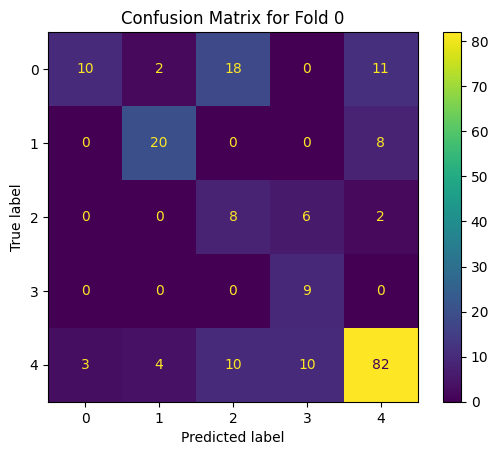

Fold 1:


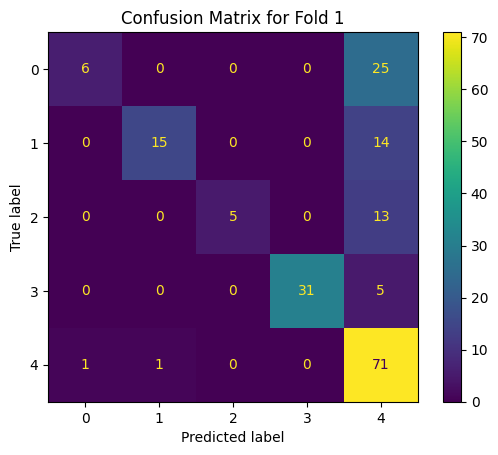

Fold 2:


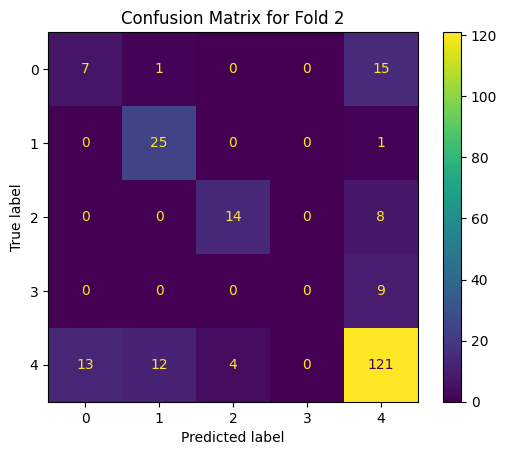

Average Accuracy: 0.682
Average Balanced Accuracy: 0.583


In [58]:
# Placeholder for cross-validation results
accuracy_scores = []
balanced_accuracy_scores = []

# Iterate over each train/test split
for i, (train_idx, test_idx) in enumerate(logo.split(X_transformed, y_tensor, groups)):
    X_train, X_test = X_transformed[train_idx], X_transformed[test_idx]
    y_train, y_test = y_tensor[train_idx], y_tensor[test_idx]

    # DataLoader for training and testing
    train_loader = DataLoader(TensorDataset(X_train, y_train), batch_size=32, shuffle=True)
    test_loader = DataLoader(TensorDataset(X_test, y_test), batch_size=32)

    # Initialize and train the model
    model = create_modified_mobilenet(num_classes=5).to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)

    # Training loop
    for epoch in range(10):  # Adjust the number of epochs if needed
        model.train()
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

    # Evaluate the model
    model.eval()
    all_preds = []
    all_labels = []
    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, predicted = torch.max(outputs.data, 1)
            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    # Calculate metrics
    accuracy = accuracy_score(all_labels, all_preds)
    balanced_acc = balanced_accuracy_score(all_labels, all_preds)
    print(f"Fold {i}:")
    disp = ConfusionMatrixDisplay.from_predictions(all_labels, all_preds)
    plt.title(f'Confusion Matrix for Fold {i}')
    plt.show()

    # Store results
    accuracy_scores.append(accuracy)
    balanced_accuracy_scores.append(balanced_acc)

# Calculate and print average metrics
average_accuracy = np.mean(accuracy_scores)
average_balanced_accuracy = np.mean(balanced_accuracy_scores)
print(f'Average Accuracy: {average_accuracy:.3f}')
print(f'Average Balanced Accuracy: {average_balanced_accuracy:.3f}')

These are the scores you will have to (and will most certainly!) beat during this challenge.

## Submitting to the online challenge: [ramp.studio](https://ramp.studio) <a class="anchor" id="submitting"></a>

Once you found a good model, you can submit them to [ramp.studio](https://www.ramp.studio) to enter the online challenge. First, if it is your first time using the RAMP platform, [sign up](https://www.ramp.studio/sign_up), otherwise [log in](https://www.ramp.studio/login). Then sign up to the event [hotjupiter](http://www.ramp.studio/events/hotjupiter_datacamp2023). Both signups are controled by RAMP administrators, so there **can be a delay between asking for signup and being able to submit**.

Once your signup request is accepted, you can go to your [sandbox](https://www.ramp.studio/events/hotjupiter_datacamp2023/sandbox) and write the code for your classifier directly on the browser. You can also create a new folder `my_submission` in the `submissions` folder containing `classifier.py` and upload this file directly. You can check the starting-kit ([`classifier.py`](/edit/submissions/starting_kit/classifier.py)) for an example. The submission is trained and tested on our backend in the similar way as `ramp-test` does it locally. While your submission is waiting in the queue and being trained, you can find it in the "New submissions (pending training)" table in [my submissions](https://www.ramp.studio/events/hotjupiter_datacamp2023/my_submissions). Once it is trained, your submission shows up on the [public leaderboard](https://www.ramp.studio/events/hotjupiter_datacamp2023/leaderboard).
If there is an error (despite having tested your submission locally with `ramp-test`), it will show up in the "Failed submissions" table in [my submissions](https://www.ramp.studio/events/hotjupiter_datacamp2023/my_submissions). You can click on the error to see part of the trace.

The data set we use at the backend is usually different from what you find in the starting kit, so the score may be different.

The usual way to work with RAMP is to explore solutions, add feature transformations, select models, etc., _locally_, and checking them with `ramp-test`. The script prints mean cross-validation scores.

The official score in this RAMP (the first score column on the [leaderboard](http://www.ramp.studio/events/hotjupiter_datacamp2023/leaderboard)) is the balenced accuracy score (`bal_acc`). When the score is good enough, you can submit it at the RAMP.

Here is the script proposed as the starting_kit:

In [ ]:
import numpy as np
import random
from sklearn.base import BaseEstimator


class Classifier(BaseEstimator):
    def __init__(self):
        return

    def fit(self, X, y):
        return

    def predict(self, X):
        return

    def predict_proba(self, X):
        # Create an array of zeros
        y_pred = np.zeros((X.shape[0], 5), dtype=int)
        # Set one random index per row to 1
        for i in range(X.shape[0]):
            random_index = random.randint(0, 4)
            y_pred[i, random_index] = 1
        return np.array(y_pred)

You can test your solution locally by running the ramp-test command followed by --submission <my_submission folder>.
Here is an example with the starting_kit submission:

In [ ]:
!ramp-test --submission starting_kit

Testing Hot Jupiter atmospheric pattern classification
Reading train and test files from ./data/ ...
Reading cv ...
Training submissions/starting_kit ...
CV fold 0
	score  bal_acc    acc      time
	train      0.2  0.535  0.010346
	valid      0.2  0.537  0.000140
	test       0.2  0.618  0.000015
CV fold 1
	score  bal_acc    acc      time
	train      0.2  0.598  0.009867
	valid      0.2  0.390  0.000143
	test       0.2  0.618  0.000018
CV fold 2
	score  bal_acc    acc      time
	train      0.2  0.467  0.009015
	valid      0.2  0.652  0.000139
	test       0.2  0.618  0.000017
----------------------------
Mean CV scores
----------------------------
	score    bal_acc             acc       time
	train  0.2 ± 0.0  0.533 ± 0.0537  0.0 ± 0.0
	valid  0.2 ± 0.0  0.526 ± 0.1071  0.0 ± 0.0
	test   0.2 ± 0.0     0.618 ± 0.0  0.0 ± 0.0
----------------------------
Bagged scores
----------------------------
	score  bal_acc    acc
	valid      0.2  0.535
	test       0.2  0.618


## More information

See the [online documentation](https://paris-saclay-cds.github.io/ramp-docs/ramp-workflow/stable/using_kits.html) for more details.

## Questions

Questions related to the starting kit should be asked on the [issue tracker](https://github.com/ramp-kits/tephra/issues).